# This notebook shows how to create an example baseclass which can be used to create a metric or a plot

In [56]:
# Basic imports
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pprint import pprint

from lsst.daf.butler import Butler

repo = "/sdf/group/rubin/u/ebellm/workspace/cosmos/repo"
collection = "ap_verify-output"

butler = Butler(repo, collections=[collection])
registry = butler.registry

In [57]:
import lsst.analysis.tools
print(lsst.analysis.tools.__file__)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/analysis_tools/ged05c40311+7eb847934c/python/lsst/analysis/tools/__init__.py


In [58]:
dataset_refs = registry.queryDatasets("fakes_deepDiff_assocDiaSrc")

In [59]:
assocDiaSources = []
for ref in dataset_refs:
    assocDiaSource = butler.getDirect(ref)
    assocDiaSources.append(assocDiaSource)

df = pd.concat(assocDiaSources)

## Example Base Class

Base classes in analysis tools are used to give plots or metric relevant data. 

The example below loads in two vectors as buildActions. Of note the names after buildAction are the same as variable names and can be anything needed to identify what you are buildoing. 

Once the given action is identified, the needed keys are loaded assigned using self.process.buildActions.CHOSENVARIABLENAME.vectorKey. For LoadVector, this is the only key needed. Other actions may need selectors to be defined, bands, or other variables.

In this example, we do not currently use any additional filter actions, and instead move straight to a calculateAction. This base class wants to create a fluxRatioMetric, which is the PSF Flux divided by the AP flux.

In [78]:
from lsst.analysis.tools.interfaces import AnalysisPlot, AnalysisTool
from lsst.analysis.tools.actions.vector import LoadVector, DivideVector

class PsfApRatioBaseClass(AnalysisTool):
    """Base class for scatter plots or metrics of PSF/Aperture Ratios.
    """

    def setDefaults(self):
        super().setDefaults()
        self.process.buildActions.loadVectorPsf = LoadVector()
        self.process.buildActions.loadVectorAp = LoadVector()
        
        # assign keys for PSF and AP Flux
        self.process.buildActions.loadVectorPsf.vectorKey = "psFlux"
        self.process.buildActions.loadVectorAp.vectorKey = "apFlux"

        self.process.calculateActions.fluxRatioMetric = DivideVector(actionA = self.process.buildActions.loadVectorPsf , actionB = self.process.buildActions.loadVectorAp )

### Creating a class to plot

Below is an example of a plot class that uses the Histogram tools in analysis tools and which uses the base class created above.

To create a plotting class which uses an existing base class, you need to have the clas inheret both from AlysisPlot and from the base class. This will mean everything within those two classes wil lappear within your plot class, and you don't have to call any of the build, filter, or calculation classess contained within the existing classes. For this example, to create a histogram you need to call HistPlot() as a self.produce and then give it panels.

If you want to create another panel, you need to change the name inside self.produce.panels["NAMEOFPANEL"]. You can provuce the panel a label and then a dictionary of hists. The dictionary in this case is the fluxRatioMetric which is built in the previous base class, and you assocciate it with a string name which will label the data on the histogram. Multiple histograms can be plotted on the same panel by giving the dictionary multiple dictionaries seperated by a comma. 

In [79]:
from lsst.analysis.tools.actions.plot.histPlot import HistPlot, HistPanel

class FluxRatioPlot(AnalysisPlot, PsfApRatioBaseClass):
    def setDefaults(self):
        super().setDefaults()
        
        self.produce = HistPlot()
        
        self.produce.panels["panel_flux"] = HistPanel()
        self.produce.panels["panel_flux"].label = "Psf/Ap Ratio"
        self.produce.panels["panel_flux"].hists = dict(fluxRatioMetric="Ratio")

In the current build, the created dictionary does not contain the required plot info, and would error after plotting the histogram. To avoid this, a fake plotInfo is built and fed into the class.

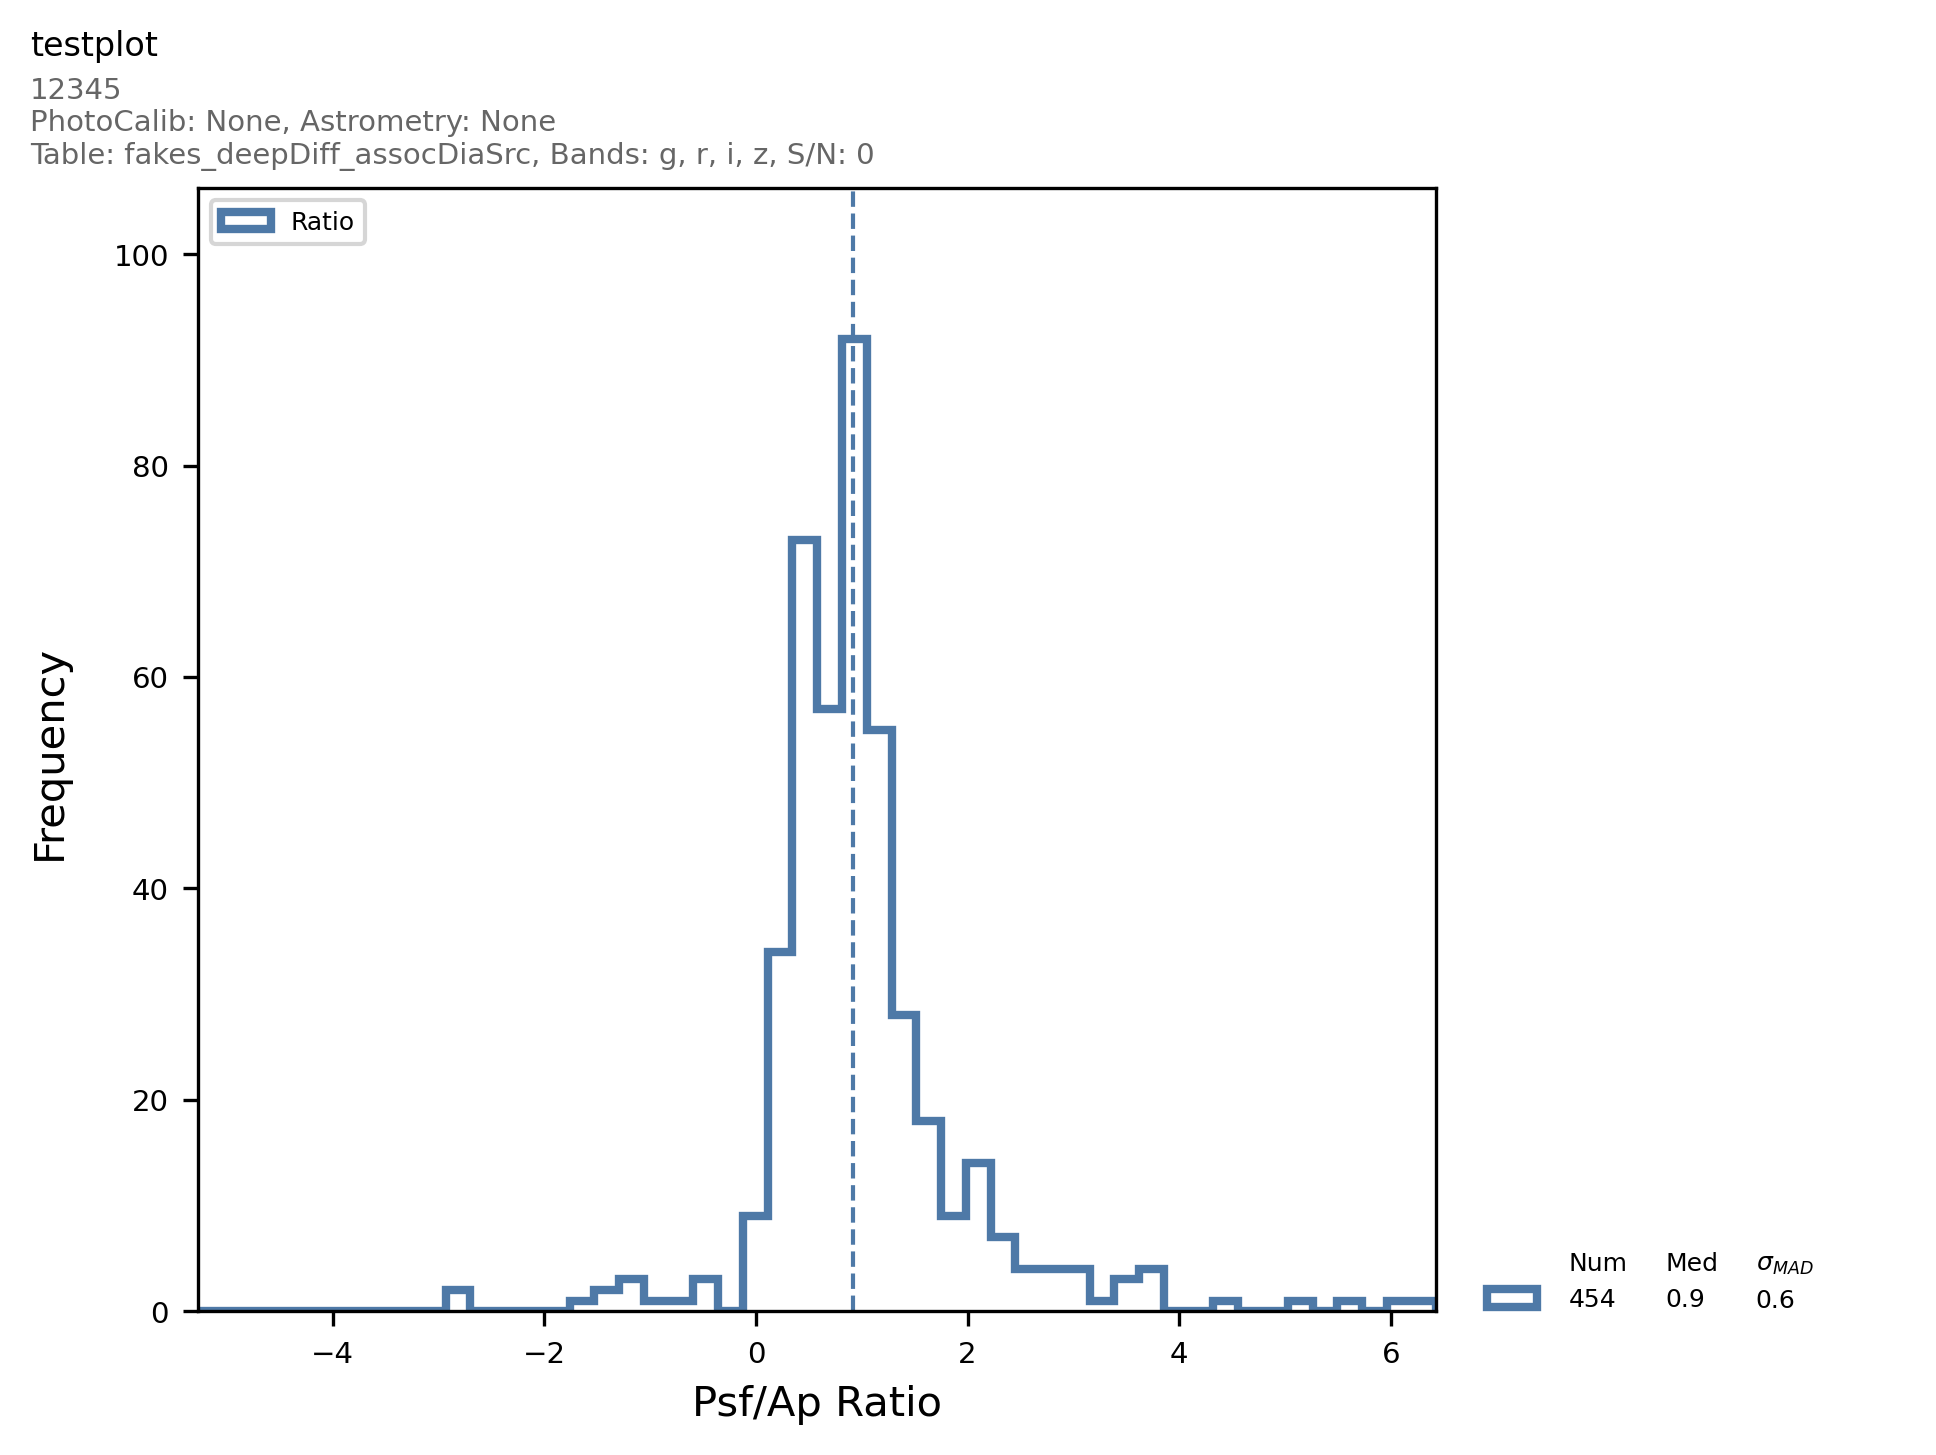

In [81]:
plotInfo={"plotName":"testplot", "run": "12345",
          "tableName":"fakes_deepDiff_assocDiaSrc",
          "bands":"griz", "SN": 0}
Bmetric = FluxRatioPlot()(df,plotInfo=plotInfo  )

### Mean Flux Metric

This is an example of a simple metric to calculate create a metric for the mean PSF, Aperture, and total fluxes. 

In this example, there is no nead to load in vectors if no filtering is desired. Instead, mean action is called and given the key directory.

In [83]:
from lsst.analysis.tools.interfaces import AnalysisMetric

from lsst.analysis.tools.actions.vector import DownselectVector, ThresholdSelector, PerGroupStatistic
from lsst.analysis.tools.actions.scalar import CountAction, MeanAction

import astropy.units as u

class FluxMeanMetric(AnalysisMetric):
    def setDefaults(self):
        super().setDefaults()
           
        self.process.calculateActions.psFluxMeanMetric = MeanAction(vectorKey = 'psFlux')
        self.process.calculateActions.apFluxMeanMetric = MeanAction(vectorKey = 'apFlux')
        self.process.calculateActions.totFluxMeanMetric = MeanAction(vectorKey = 'totFlux')

        self.produce.units = {"psFluxMeanMetric": "flx","apFluxMeanMetric": "flx", "totFluxMeanMetric": "flx"}

In [84]:
# make some fake data
metric = FluxMeanMetric()(df)
print(metric)

{'psFluxMeanMetric': Measurement('psFluxMeanMetric', <Quantity 3670.57372023 flx>), 'apFluxMeanMetric': Measurement('apFluxMeanMetric', <Quantity 5431.98431446 flx>), 'totFluxMeanMetric': Measurement('totFluxMeanMetric', <Quantity 12308.63473155 flx>)}


In [85]:
list(df)

['diaSourceId',
 'ccdVisitId',
 'filterName',
 'diaObjectId',
 'ssObjectId',
 'parentDiaSourceId',
 'midPointTai',
 'bboxSize',
 'flags',
 'ra',
 'decl',
 'x',
 'y',
 'xErr',
 'yErr',
 'apFlux',
 'apFluxErr',
 'snr',
 'psFlux',
 'psFluxErr',
 'psChi2',
 'psNdata',
 'trailFlux',
 'trailRa',
 'trailDecl',
 'trailLength',
 'trailAngle',
 'dipMeanFlux',
 'dipMeanFluxErr',
 'dipFluxDiff',
 'dipFluxDiffErr',
 'dipLength',
 'dipAngle',
 'dipChi2',
 'isDipole',
 'totFlux',
 'totFluxErr',
 'ixx',
 'iyy',
 'ixy',
 'ixxPSF',
 'iyyPSF',
 'ixyPSF',
 'programId']